# SI 670 Final Project - Predicting Soccer Players' Market Value Based on FIFA Stats

## By Sammy Stern and Yash Kamat

### Imports and Basic Data Exploration

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.tree import ExtraTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures

from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from mlxtend.evaluate import bias_variance_decomp

from warnings import filterwarnings

filterwarnings('ignore')
SEED = 0

In [2]:
df = pd.read_csv('fifa_data.csv')

In [3]:
df.head()

,Player,Overall Score,Potential Score,Market Value,Salary,Height,Weight,Age,Preferred Foot,Ball Control,...,Long Shots,Curve,FK Acc.,Penalties,Volleys,GK Positioning,GK Diving,GK Handling,GK Kicking,GK Reflexes
0,Lionel Messi,93,93,92000000.0,380000.0,170,72,34,Left,96.0,...,94.0,93.0,94.0,75.0,88.0,14.0,6.0,11.0,15.0,8.0
1,Robert Lewandowski,92,92,141500000.0,320000.0,185,81,33,Right,88.0,...,87.0,79.0,85.0,89.0,89.0,8.0,15.0,6.0,12.0,10.0
2,Kylian Mbappé,91,95,229000000.0,270000.0,182,73,22,Right,91.0,...,82.0,80.0,69.0,79.0,83.0,11.0,13.0,5.0,7.0,6.0
3,Jan Oblak,91,93,132500000.0,150000.0,188,87,28,Right,30.0,...,12.0,13.0,14.0,11.0,13.0,90.0,87.0,92.0,78.0,90.0
4,Kevin De Bruyne,91,91,148000000.0,410000.0,181,70,30,Right,90.0,...,91.0,85.0,83.0,83.0,82.0,10.0,15.0,13.0,5.0,13.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 43 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Player           3000 non-null   object 
 1   Overall Score    3000 non-null   int64  
 2   Potential Score  3000 non-null   int64  
 3   Market Value     2933 non-null   float64
 4   Salary           2945 non-null   float64
 5   Height           3000 non-null   int64  
 6   Weight           3000 non-null   int64  
 7   Age              3000 non-null   int64  
 8   Preferred Foot   3000 non-null   object 
 9   Ball Control     2973 non-null   float64
 10  Dribbling        2979 non-null   float64
 11  Marking          2975 non-null   float64
 12  Slide Tackle     2980 non-null   float64
 13  Stand Tackle     2977 non-null   float64
 14  Aggression       2984 non-null   float64
 15  Reactions        2962 non-null   float64
 16  Att. Position    2980 non-null   float64
 17  Interceptions 

In [5]:
df.isnull().sum()

Player              0
Overall Score       0
Potential Score     0
Market Value       67
Salary             55
Height              0
Weight              0
Age                 0
Preferred Foot      0
Ball Control       27
Dribbling          21
Marking            25
Slide Tackle       20
Stand Tackle       23
Aggression         16
Reactions          38
Att. Position      20
Interceptions      26
Vision             19
Composure          19
Crossing           19
Short Pass         32
Long Pass          18
Acceleration       20
Stamina            24
Strength           25
Balance             6
Sprint Speed       21
Agility            14
Jumping             8
Heading            16
Shot Power         12
Finishing          22
Long Shots         13
Curve              10
FK Acc.            11
Penalties           4
Volleys             9
GK Positioning      2
GK Diving           1
GK Handling         1
GK Kicking          0
GK Reflexes         2
dtype: int64

We have multiple columns with missing values. Most importantly, the target column, `Market Value` has 67 missing values, which we cannot (and should not) impute, since it's the target column. As such, we will drop the `Market Value` column and impute the missing value in the remaining columns.

In [6]:
df[df['Market Value'].isnull()]

,Player,Overall Score,Potential Score,Market Value,Salary,Height,Weight,Age,Preferred Foot,Ball Control,...,Long Shots,Curve,FK Acc.,Penalties,Volleys,GK Positioning,GK Diving,GK Handling,GK Kicking,GK Reflexes
172,Toby Alderweireld,83,83,NaN,NaN,186,81,32,Right,75.0,...,58.0,63.0,59.0,58.0,38.0,16.0,16.0,6.0,14.0,14.0
212,Andreas Christensen,82,86,NaN,NaN,188,81,25,Right,NaN,...,20.0,41.0,39.0,36.0,25.0,6.0,10.0,12.0,8.0,8.0
221,Saúl,82,83,NaN,75000.0,184,75,27,Left,82.0,...,80.0,73.0,60.0,68.0,76.0,10.0,7.0,13.0,12.0,9.0
310,Andreas Christensen,82,86,NaN,NaN,188,81,25,Right,NaN,...,20.0,41.0,39.0,36.0,25.0,6.0,10.0,12.0,8.0,8.0
376,Scott McTominay,80,83,NaN,105000.0,193,88,24,Right,76.0,...,81.0,72.0,53.0,60.0,62.0,10.0,9.0,6.0,6.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2782,Guillermo Fernández,73,73,NaN,NaN,178,75,30,Right,76.0,...,76.0,75.0,74.0,59.0,NaN,11.0,9.0,14.0,6.0,6.0
2843,Jakub Brabec,73,73,NaN,NaN,187,77,29,Right,66.0,...,56.0,39.0,29.0,49.0,51.0,16.0,10.0,12.0,6.0,7.0
2895,Guido Burgstaller,73,73,NaN,NaN,187,80,32,Right,69.0,...,70.0,62.0,42.0,64.0,72.0,10.0,12.0,7.0,14.0,9.0
2904,Romain Hamouma,73,73,NaN,NaN,178,76,34,Right,NaN,...,NaN,76.0,70.0,70.0,76.0,7.0,14.0,11.0,14.0,13.0


In [7]:
df.dropna(subset=['Market Value'], inplace=True)

In [8]:
df.shape

(2933, 43)

In [9]:
df.isnull().sum()

Player              0
Overall Score       0
Potential Score     0
Market Value        0
Salary              0
Height              0
Weight              0
Age                 0
Preferred Foot      0
Ball Control        4
Dribbling           4
Marking             7
Slide Tackle        8
Stand Tackle        8
Aggression          9
Reactions           7
Att. Position       3
Interceptions       9
Vision              4
Composure           4
Crossing            3
Short Pass          6
Long Pass           3
Acceleration       12
Stamina            12
Strength           14
Balance             5
Sprint Speed       15
Agility             7
Jumping             2
Heading             5
Shot Power          4
Finishing           6
Long Shots          5
Curve               3
FK Acc.             8
Penalties           1
Volleys             1
GK Positioning      0
GK Diving           1
GK Handling         0
GK Kicking          0
GK Reflexes         0
dtype: int64

## Feature Representation

Splitting dataframe into two dataframes - one for player information (containing numerical and text data) and one for player statistics (conatining only numerical data).

In [10]:
df_info = df[['Market Value', 'Salary', 'Height', 'Weight', 'Age', 'Preferred Foot']]
df_stat = df.drop(['Player', 'Salary', 'Height', 'Weight', 'Age', 'Preferred Foot'], axis=1)

In [11]:
df_info.head()

,Market Value,Salary,Height,Weight,Age,Preferred Foot
0,92000000.0,380000.0,170,72,34,Left
1,141500000.0,320000.0,185,81,33,Right
2,229000000.0,270000.0,182,73,22,Right
3,132500000.0,150000.0,188,87,28,Right
4,148000000.0,410000.0,181,70,30,Right


In [12]:
df_stat.head().T

,0,1,2,3,4
Overall Score,93.0,92.0,91.0,91.0,91.0
Potential Score,93.0,92.0,95.0,93.0,91.0
Market Value,92000000.0,141500000.0,229000000.0,132500000.0,148000000.0
Ball Control,96.0,88.0,91.0,30.0,90.0
Dribbling,96.0,85.0,93.0,12.0,88.0
Marking,20.0,35.0,26.0,27.0,68.0
Slide Tackle,24.0,19.0,32.0,18.0,53.0
Stand Tackle,35.0,42.0,34.0,12.0,65.0
Aggression,44.0,81.0,62.0,34.0,75.0
Reactions,94.0,93.0,93.0,88.0,91.0


### Encode Categorical Features

In [13]:
df_info['Preferred Foot'] = df_info['Preferred Foot'].apply(lambda x: 0 if x=='Left' else 1)

### Impute Missing Values

In [14]:
df_info.isnull().sum()

Market Value      0
Salary            0
Height            0
Weight            0
Age               0
Preferred Foot    0
dtype: int64

In [15]:
df_stat.isnull().sum()

Overall Score       0
Potential Score     0
Market Value        0
Ball Control        4
Dribbling           4
Marking             7
Slide Tackle        8
Stand Tackle        8
Aggression          9
Reactions           7
Att. Position       3
Interceptions       9
Vision              4
Composure           4
Crossing            3
Short Pass          6
Long Pass           3
Acceleration       12
Stamina            12
Strength           14
Balance             5
Sprint Speed       15
Agility             7
Jumping             2
Heading             5
Shot Power          4
Finishing           6
Long Shots          5
Curve               3
FK Acc.             8
Penalties           1
Volleys             1
GK Positioning      0
GK Diving           1
GK Handling         0
GK Kicking          0
GK Reflexes         0
dtype: int64

In [16]:
imputer = SimpleImputer(strategy='median')
df_stat_index = df_stat.index
df_stat_columns = df_stat.columns
df_stat = pd.DataFrame(imputer.fit_transform(df_stat), index=df_stat_index, columns=df_stat_columns)
df_stat

,Overall Score,Potential Score,Market Value,Ball Control,Dribbling,Marking,Slide Tackle,Stand Tackle,Aggression,Reactions,...,Long Shots,Curve,FK Acc.,Penalties,Volleys,GK Positioning,GK Diving,GK Handling,GK Kicking,GK Reflexes
0,93.0,93.0,92000000.0,96.0,96.0,20.0,24.0,35.0,44.0,94.0,...,94.0,93.0,94.0,75.0,88.0,14.0,6.0,11.0,15.0,8.0
1,92.0,92.0,141500000.0,88.0,85.0,35.0,19.0,42.0,81.0,93.0,...,87.0,79.0,85.0,89.0,89.0,8.0,15.0,6.0,12.0,10.0
2,91.0,95.0,229000000.0,91.0,93.0,26.0,32.0,34.0,62.0,93.0,...,82.0,80.0,69.0,79.0,83.0,11.0,13.0,5.0,7.0,6.0
3,91.0,93.0,132500000.0,30.0,12.0,27.0,18.0,12.0,34.0,88.0,...,12.0,13.0,14.0,11.0,13.0,90.0,87.0,92.0,78.0,90.0
4,91.0,91.0,148000000.0,90.0,88.0,68.0,53.0,65.0,75.0,91.0,...,91.0,85.0,83.0,83.0,82.0,10.0,15.0,13.0,5.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,73.0,73.0,1200000.0,79.0,75.0,44.0,25.0,29.0,73.0,70.0,...,74.0,80.0,75.0,80.0,66.0,15.0,6.0,11.0,12.0,6.0
2996,73.0,73.0,1200000.0,82.0,82.0,23.0,35.0,40.0,52.0,70.0,...,76.0,80.0,74.0,73.0,78.0,6.0,10.0,14.0,10.0,15.0
2997,73.0,73.0,1400000.0,74.0,71.0,50.0,50.0,54.0,58.0,71.0,...,76.0,81.0,75.0,80.0,69.0,12.0,14.0,9.0,12.0,9.0
2998,73.0,73.0,1200000.0,76.0,75.0,57.0,26.0,30.0,73.0,72.0,...,75.0,76.0,71.0,77.0,71.0,9.0,15.0,11.0,15.0,9.0


In [17]:
df_stat.isnull().sum().sum()

0

### Create Custom Features

In [18]:
df_stat['Pace'] = (df_stat['Acceleration'] + df_stat['Sprint Speed'])/2
df_stat['Shooting'] = round((df_stat['Att. Position'] + df_stat['Finishing'] + df_stat['Shot Power'] + 
                       df_stat['Long Shots'] + df_stat['Volleys'] + df_stat['Penalties'])/6, 1)
df_stat['Passing'] = round((df_stat['Vision'] + df_stat['Crossing'] + df_stat['FK Acc.'] + 
                       df_stat['Short Pass'] + df_stat['Long Pass'] + df_stat['Curve'])/6, 1)
df_stat['Dribbling_Ovr'] = round((df_stat['Agility'] + df_stat['Balance'] + df_stat['Reactions'] + 
                       df_stat['Ball Control'] + df_stat['Dribbling'] + df_stat['Composure'])/6, 1)
df_stat['Defending'] = round((df_stat['Interceptions'] + df_stat['Heading']  + 
                       df_stat['Stand Tackle'] + df_stat['Slide Tackle'])/4, 1)
df_stat['Physical'] = round((df_stat['Jumping'] + df_stat['Stamina'] + df_stat['Strength'] + 
                       df_stat['Aggression'])/4, 1)

In [19]:
df_stat.head()

,Overall Score,Potential Score,Market Value,Ball Control,Dribbling,Marking,Slide Tackle,Stand Tackle,Aggression,Reactions,...,GK Diving,GK Handling,GK Kicking,GK Reflexes,Pace,Shooting,Passing,Dribbling_Ovr,Defending,Physical
0,93.0,93.0,92000000.0,96.0,96.0,20.0,24.0,35.0,44.0,94.0,...,6.0,11.0,15.0,8.0,85.5,88.5,91.5,94.7,42.2,63.2
1,92.0,92.0,141500000.0,88.0,85.0,35.0,19.0,42.0,81.0,93.0,...,15.0,6.0,12.0,10.0,78.0,90.8,78.5,85.5,50.0,82.0
2,91.0,95.0,229000000.0,91.0,93.0,26.0,32.0,34.0,62.0,93.0,...,13.0,5.0,7.0,6.0,97.0,85.8,77.5,90.0,44.0,76.2
3,91.0,93.0,132500000.0,30.0,12.0,27.0,18.0,12.0,34.0,88.0,...,87.0,92.0,78.0,90.0,51.5,19.5,31.3,52.3,16.0,57.8
4,91.0,91.0,148000000.0,90.0,88.0,68.0,53.0,65.0,75.0,91.0,...,15.0,13.0,5.0,13.0,76.0,86.0,90.3,85.8,59.8,75.0


## Correlation & Feature Importance

### For df_info

In [20]:
df_info.corr()['Market Value'].sort_values(key=abs, ascending=False)

Market Value      1.000000
Salary            0.745820
Age              -0.241776
Weight           -0.014645
Preferred Foot   -0.007229
Height            0.001692
Name: Market Value, dtype: float64

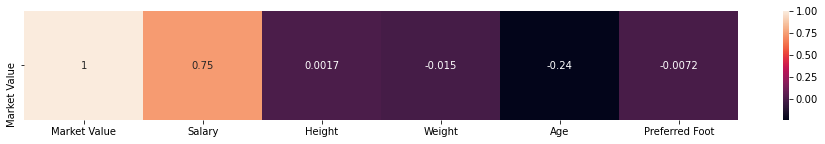

In [21]:
plt.figure(figsize=(16,2))
sns.heatmap(df_info.corr().loc[['Market Value'],:], annot=True)
plt.show()

In [22]:
feat_import_tree = ExtraTreeRegressor(random_state=SEED)

temp_X = df_info.drop('Market Value', axis=1)
temp_y = df_info['Market Value']
feat_import_tree.fit(temp_X, temp_y)

ExtraTreeRegressor(random_state=0)

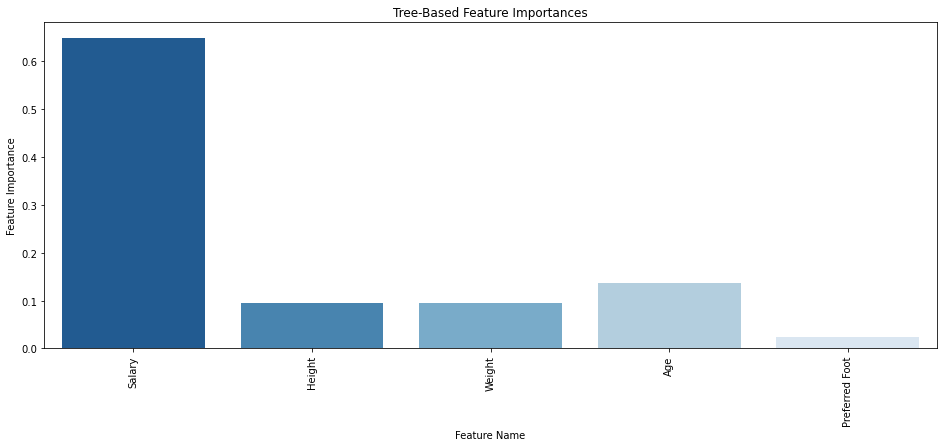

In [23]:
plt.figure(figsize=(16,6))
plt.xticks(rotation=90)
sns.barplot(y=feat_import_tree.feature_importances_, x=temp_X.columns, palette='Blues_r')
plt.title('Tree-Based Feature Importances')
plt.xlabel('Feature Name')
plt.ylabel('Feature Importance')
plt.show()

**Observation**: Given that most features in the player information dataset do not perform well in either correlation or in tree based feature importance, we will pivot to feature **ablation** moving forward, where we will build models using two datasets: a) **df_stat**: containing only numerical data and b) **df_full**: Entire dataset containing numerical and categorical features.

### For df_stat

In [24]:
df_stat.corr()['Market Value'].sort_values(key=abs, ascending=False)

Market Value       1.000000
Overall Score      0.830664
Potential Score    0.768756
Reactions          0.639481
Composure          0.369874
Dribbling_Ovr      0.301930
Vision             0.293824
Short Pass         0.259410
Ball Control       0.235474
Passing            0.233918
Shot Power         0.231843
Long Pass          0.224415
Sprint Speed       0.221873
Pace               0.221788
Dribbling          0.217812
Acceleration       0.211144
Shooting           0.201896
Finishing          0.200563
Agility            0.197206
Att. Position      0.195520
Volleys            0.194799
Curve              0.194696
Stamina            0.186976
Long Shots         0.174376
Crossing           0.172144
Balance            0.161680
FK Acc.            0.156342
Penalties          0.145591
Physical           0.129772
Heading            0.096706
Aggression         0.083467
Defending          0.067284
Marking            0.059357
GK Handling       -0.058691
Interceptions      0.057963
Stand Tackle       0

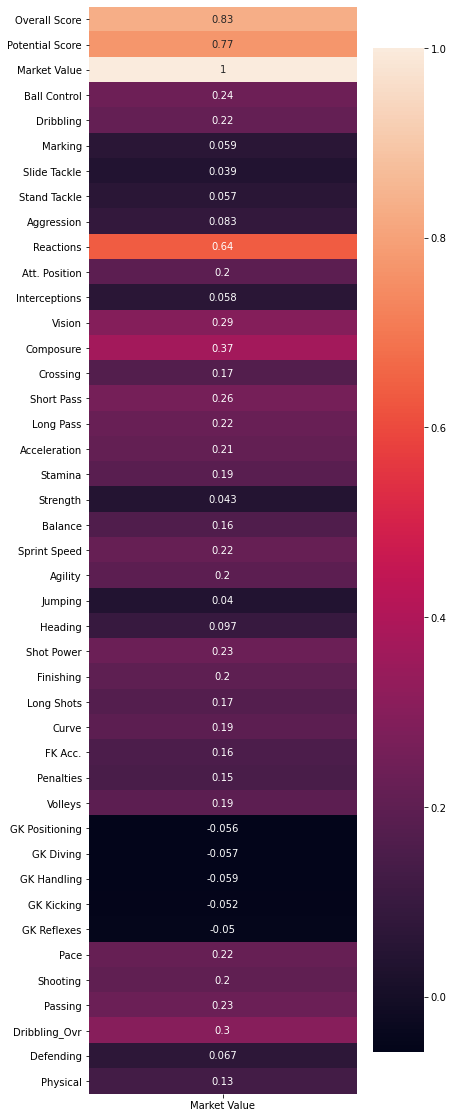

In [25]:
plt.figure(figsize=(6,20))
sns.heatmap(df_stat.corr().loc[['Market Value'],:].T, annot=True)
plt.show()

In [26]:
feat_import_tree = ExtraTreeRegressor(random_state=SEED)

temp_X = df_stat.drop('Market Value', axis=1)
temp_y = df_stat['Market Value']
feat_import_tree.fit(temp_X, temp_y)

ExtraTreeRegressor(random_state=0)

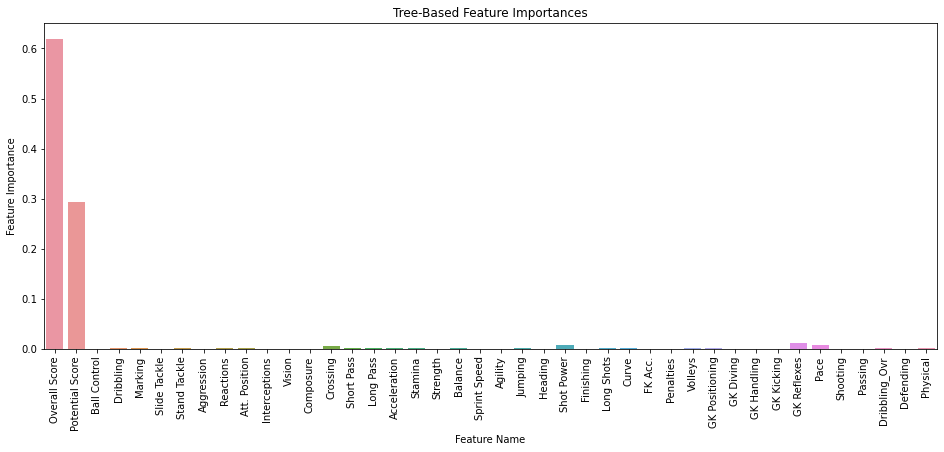

In [27]:
plt.figure(figsize=(16,6))
plt.xticks(rotation=90)
sns.barplot(y=feat_import_tree.feature_importances_, x=temp_X.columns)
plt.title('Tree-Based Feature Importances')
plt.xlabel('Feature Name')
plt.ylabel('Feature Importance')
plt.show()

In [28]:
df_stat.corr()['Market Value'].sort_values(key=abs, ascending=False)[:10]

Market Value       1.000000
Overall Score      0.830664
Potential Score    0.768756
Reactions          0.639481
Composure          0.369874
Dribbling_Ovr      0.301930
Vision             0.293824
Short Pass         0.259410
Ball Control       0.235474
Passing            0.233918
Name: Market Value, dtype: float64

**Observation**: We wish to pick features with a correlation threshold of at least 0.25, hence we will pick the top 7 features for df_stat.

### For df_full

In [29]:
df_full = df_stat.join(df_info.drop('Market Value', axis=1), how='inner')
df_full.head()

,Overall Score,Potential Score,Market Value,Ball Control,Dribbling,Marking,Slide Tackle,Stand Tackle,Aggression,Reactions,...,Shooting,Passing,Dribbling_Ovr,Defending,Physical,Salary,Height,Weight,Age,Preferred Foot
0,93.0,93.0,92000000.0,96.0,96.0,20.0,24.0,35.0,44.0,94.0,...,88.5,91.5,94.7,42.2,63.2,380000.0,170,72,34,0
1,92.0,92.0,141500000.0,88.0,85.0,35.0,19.0,42.0,81.0,93.0,...,90.8,78.5,85.5,50.0,82.0,320000.0,185,81,33,1
2,91.0,95.0,229000000.0,91.0,93.0,26.0,32.0,34.0,62.0,93.0,...,85.8,77.5,90.0,44.0,76.2,270000.0,182,73,22,1
3,91.0,93.0,132500000.0,30.0,12.0,27.0,18.0,12.0,34.0,88.0,...,19.5,31.3,52.3,16.0,57.8,150000.0,188,87,28,1
4,91.0,91.0,148000000.0,90.0,88.0,68.0,53.0,65.0,75.0,91.0,...,86.0,90.3,85.8,59.8,75.0,410000.0,181,70,30,1


In [30]:
feat_import_tree = ExtraTreeRegressor(random_state=SEED)

temp_X = df_full.drop('Market Value', axis=1)
temp_y = df_full['Market Value']
feat_import_tree.fit(temp_X, temp_y)

ExtraTreeRegressor(random_state=0)

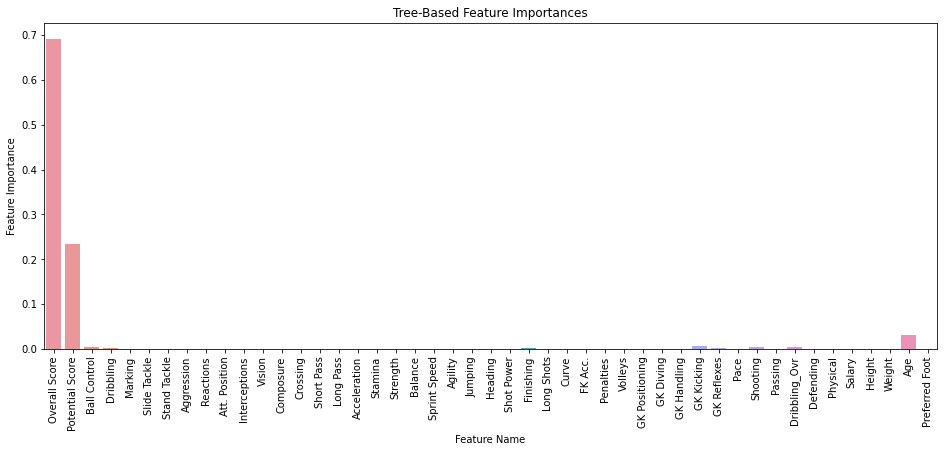

In [31]:
plt.figure(figsize=(16,6))
plt.xticks(rotation=90)
sns.barplot(y=feat_import_tree.feature_importances_, x=temp_X.columns)
plt.title('Tree-Based Feature Importances')
plt.xlabel('Feature Name')
plt.ylabel('Feature Importance')
plt.show()

In [32]:
df_full.corr()['Market Value'].sort_values(key=abs, ascending=False)[:10]

Market Value       1.000000
Overall Score      0.830664
Potential Score    0.768756
Salary             0.745820
Reactions          0.639481
Composure          0.369874
Dribbling_Ovr      0.301930
Vision             0.293824
Short Pass         0.259410
Age               -0.241776
Name: Market Value, dtype: float64

**Observation**: We wish to pick features with a correlation threshold of at least 0.25, hence we will pick the top 7 features for df_stat. However, since `Salary` is the only feature from `df_info` included under this threshold, we will also include `Age` as well for proper feature comparison.

# Initial Model Building

In this section, we will use a simple train-test split to gauge the initial effectiveness of different regression models. This is **NOT** the final evaluation and simply a method to test how different models are performing with the given data. We will then carry forward the two baseline models along with 3-4 well performing models and conduct a more thorough analysis in the next section.

## Train-Test Split and Scaling

### df_stat

In [33]:
df_stat_final = df_stat[df_stat.corr()['Market Value'].sort_values(key=abs, ascending=False)[:7].index]
df_stat_final.head()

,Market Value,Overall Score,Potential Score,Reactions,Composure,Dribbling_Ovr,Vision
0,92000000.0,93.0,93.0,94.0,96.0,94.7,95.0
1,141500000.0,92.0,92.0,93.0,88.0,85.5,81.0
2,229000000.0,91.0,95.0,93.0,88.0,90.0,82.0
3,132500000.0,91.0,93.0,88.0,68.0,52.3,65.0
4,148000000.0,91.0,91.0,91.0,89.0,85.8,94.0


In [34]:
X_stat = df_stat_final.drop('Market Value', axis=1)
y_stat = df_stat_final['Market Value']

In [35]:
X_stat_train, X_stat_test, y_stat_train, y_stat_test = train_test_split(X_stat, y_stat, random_state=SEED)

In [36]:
scaler = MinMaxScaler()
X_stat_train_scaled = scaler.fit_transform(X_stat_train)
X_stat_test_scaled = scaler.transform(X_stat_test)

### df_full

In [37]:
df_full_final = df_full[df_full.corr()['Market Value'].sort_values(key=abs, ascending=False)[:10].index]
df_full_final.head()

,Market Value,Overall Score,Potential Score,Salary,Reactions,Composure,Dribbling_Ovr,Vision,Short Pass,Age
0,92000000.0,93.0,93.0,380000.0,94.0,96.0,94.7,95.0,91.0,34
1,141500000.0,92.0,92.0,320000.0,93.0,88.0,85.5,81.0,85.0,33
2,229000000.0,91.0,95.0,270000.0,93.0,88.0,90.0,82.0,85.0,22
3,132500000.0,91.0,93.0,150000.0,88.0,68.0,52.3,65.0,43.0,28
4,148000000.0,91.0,91.0,410000.0,91.0,89.0,85.8,94.0,93.0,30


In [38]:
X_full = df_full_final.drop('Market Value', axis=1)
y_full = df_full_final['Market Value']

In [39]:
X_full_train, X_full_test, y_full_train, y_full_test = train_test_split(X_full, y_full, random_state=SEED)

In [40]:
scaler = MinMaxScaler()
X_full_train_scaled = scaler.fit_transform(X_full_train)
X_full_test_scaled = scaler.transform(X_full_test)

### Base Model Building

#### With df_stats

In [41]:
dummy = DummyRegressor()
nb = GaussianNB()
lr = LinearRegression()
lasso = Lasso()
ridge = Ridge()
dt = DecisionTreeRegressor()
rf = RandomForestRegressor()
svr = SVR()
knn = KNeighborsRegressor()

model_list = [dummy, nb, lr, lasso, ridge, dt, rf, svr, knn]

for model in model_list:
    model.fit(X_stat_train_scaled, y_stat_train)
    y_pred = model.predict(X_stat_test_scaled)

    r2 = r2_score(y_stat_test, y_pred)
    mae = mean_absolute_error(y_stat_test, y_pred)
    mse = mean_squared_error(y_stat_test, y_pred)
    print(f'{str(model)[:-2]:22} R2: {round(r2, 3):5},   MAE: {round(mae,2):11},   MSE: {round(mse,2)}')

DummyRegressor         R2:  -0.0,   MAE: 10925138.94,   MSE: 277044879016142.56
GaussianNB             R2: 0.797,   MAE:  3836074.93,   MSE: 56234150559945.51
LinearRegression       R2: 0.766,   MAE:  5223573.24,   MSE: 64779538012872.66
Lasso                  R2: 0.766,   MAE:  5223569.88,   MSE: 64779506859676.19
Ridge                  R2: 0.767,   MAE:  5180633.92,   MSE: 64438419940671.86
DecisionTreeRegressor  R2: 0.801,   MAE:  2688664.85,   MSE: 55148226634877.38
RandomForestRegressor  R2: 0.921,   MAE:  1970027.54,   MSE: 21806023027576.19
SVR                    R2: -0.166,   MAE:  9676765.73,   MSE: 323048867835332.0
KNeighborsRegressor    R2: 0.913,   MAE:  2397575.75,   MSE: 24194214110572.2


#### With df_full

In [42]:
dummy = DummyRegressor()
nb = GaussianNB()
lr = LinearRegression()
lasso = Lasso()
ridge = Ridge()
dt = DecisionTreeRegressor()
rf = RandomForestRegressor()
svr = SVR()
knn = KNeighborsRegressor()

model_list = [dummy, nb, lr, lasso, ridge, dt, rf, svr, knn]

for model in model_list:
    model.fit(X_full_train_scaled, y_full_train)
    y_pred = model.predict(X_full_test_scaled)

    r2 = r2_score(y_full_test, y_pred)
    mae = mean_absolute_error(y_full_test, y_pred)
    mse = mean_squared_error(y_full_test, y_pred)
    print(f'{str(model)[:-2]:22} R2: {round(r2, 3):5},   MAE: {round(mae,2):11},   MSE: {round(mse,2)}')

DummyRegressor         R2:  -0.0,   MAE: 10925138.94,   MSE: 277044879016142.56
GaussianNB             R2: 0.824,   MAE:  3311246.59,   MSE: 48696598739782.02
LinearRegression       R2:  0.83,   MAE:  4758991.88,   MSE: 47210649041883.88
Lasso                  R2:  0.83,   MAE:  4758986.91,   MSE: 47210621164569.83
Ridge                  R2: 0.831,   MAE:  4709423.74,   MSE: 46888478299351.2
DecisionTreeRegressor  R2: 0.944,   MAE:  1350211.17,   MSE: 15555965292915.53
RandomForestRegressor  R2: 0.982,   MAE:   940664.22,   MSE: 4870248020158.31
SVR                    R2: -0.166,   MAE:   9676806.8,   MSE: 323050221990760.1
KNeighborsRegressor    R2: 0.958,   MAE:  1702988.01,   MSE: 11646628309318.8


### Model Evaluation

In this section we will evaluate the models selected from the previous section and perform an evaluation across three metrics: ${R}^2$, RMSE and MAE across a 5-fold cross validation.

In [43]:
def evaluate_model(df, model_tuple, metric, poly_deg=None):
    kfold = KFold(n_splits=5, shuffle=True, random_state=SEED)
    model = model_tuple[1]
    
    scores = []
    
    X = df.drop('Market Value', axis=1)
    y = df['Market Value']
    
    for train_idx, test_idx in kfold.split(X):
        
        X_train = X.iloc[train_idx]
        X_test = X.iloc[test_idx]
        
        y_train = y.iloc[train_idx]
        y_test = y.iloc[test_idx]
        
        scaler = MinMaxScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        if model_tuple[0].startswith('Poly'):
            poly = PolynomialFeatures(poly_deg)
            X_train_poly = poly.fit_transform(X_train_scaled)
            X_test_poly = poly.transform(X_test_scaled)

            model.fit(X_train_poly, y_train)
            y_pred = model.predict(X_test_poly)

        else:
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
        
        if metric=='r2':
            scores.append(r2_score(y_test, y_pred))
        elif metric=='rmse':
            scores.append(mean_squared_error(y_test, y_pred, squared=False))
        elif metric=='mae':
            scores.append(mean_absolute_error(y_test, y_pred))
    
    mean_score = round(np.mean(scores), 3)
    std_score = round(np.std(scores), 3)
    
    return (mean_score, std_score)

In [44]:
nb = GaussianNB()
lr = LinearRegression()
# pr = LinearRegression()
dt = DecisionTreeRegressor(random_state=SEED)
rf = RandomForestRegressor(random_state=SEED)
knn = KNeighborsRegressor()

updated_model_dict = {'DummyRegressor':dummy,
                      'NaiveBayes': nb,
                      'LinearRegression': lr,
#                       'PolynomialRegression': pr,
                      'DecisionTree': dt,
                      'RandomForest': rf,
                      'KNN': knn}

#### For df_stat

In [45]:
for name, model in updated_model_dict.items():
    print(f'{name} R^2:', evaluate_model(df_stat, (name, model), 'r2'))
    print(f'{name} RMSE:', evaluate_model(df_stat, (name, model), 'rmse'))
    print(f'{name} MAE:', evaluate_model(df_stat, (name, model), 'mae'))
    print('\n')

DummyRegressor R^2: (-0.0, 0.0)
DummyRegressor RMSE: (18207190.152, 1236168.269)
DummyRegressor MAE: (11411453.811, 482498.539)


NaiveBayes R^2: (0.457, 0.076)
NaiveBayes RMSE: (13351085.783, 868956.543)
NaiveBayes MAE: (7461524.901, 615183.371)


LinearRegression R^2: (0.756, 0.021)
LinearRegression RMSE: (8994860.271, 922445.904)
LinearRegression MAE: (5344937.106, 215792.864)


DecisionTree R^2: (0.746, 0.039)
DecisionTree RMSE: (9150829.874, 966146.796)
DecisionTree MAE: (2947461.729, 178503.185)


RandomForest R^2: (0.92, 0.021)
RandomForest RMSE: (5146502.048, 946558.626)
RandomForest MAE: (1942032.583, 159973.477)


KNN R^2: (0.783, 0.033)
KNN RMSE: (8481324.608, 1057572.252)
KNN MAE: (4043155.092, 231468.532)




### For df_full

In [46]:
for name, model in updated_model_dict.items():
    print(f'{name} R^2:', evaluate_model(df_full, (name, model), 'r2'))
    print(f'{name} RMSE:', evaluate_model(df_full, (name, model), 'rmse'))
    print(f'{name} MAE:', evaluate_model(df_full, (name, model), 'mae'))
    print('\n')

DummyRegressor R^2: (-0.0, 0.0)
DummyRegressor RMSE: (18207190.152, 1236168.269)
DummyRegressor MAE: (11411453.811, 482498.539)


NaiveBayes R^2: (0.527, 0.089)
NaiveBayes RMSE: (12425794.42, 1207226.186)
NaiveBayes MAE: (7657330.254, 568828.367)


LinearRegression R^2: (0.807, 0.011)
LinearRegression RMSE: (8010778.393, 739012.61)
LinearRegression MAE: (4827108.496, 127664.914)


DecisionTree R^2: (0.823, 0.058)
DecisionTree RMSE: (7580223.879, 1416795.137)
DecisionTree MAE: (1969282.796, 172899.799)


RandomForest R^2: (0.95, 0.021)
RandomForest RMSE: (4023256.839, 1114006.297)
RandomForest MAE: (1141869.342, 131333.372)


KNN R^2: (0.773, 0.03)
KNN RMSE: (8686194.982, 1094698.648)
KNN MAE: (4128000.373, 211809.599)




### Hyper Parameter Tuning

#### For Polynomial Regression

Performing hyperparameter tuning over a 5-fold CV for different exponents for Polynomial REgression was proving to be too computationally challenging. Hence, only for this model, we have selected a hyperparameter using a simple train test split. Note that the final model will still be evaluated using a train-test split.

In [49]:
# df_stat
scores_stat = []
for degree in range(1,10):
    poly = PolynomialFeatures(degree)
    X_stat_train_poly = poly.fit_transform(X_stat_train_scaled)
    X_stat_test_poly = poly.transform(X_stat_test_scaled)
    
    lr = LinearRegression().fit(X_stat_train_poly, y_stat_train)
    scores_stat.append(r2_score(y_stat_test, lr.predict(X_stat_test_poly)))

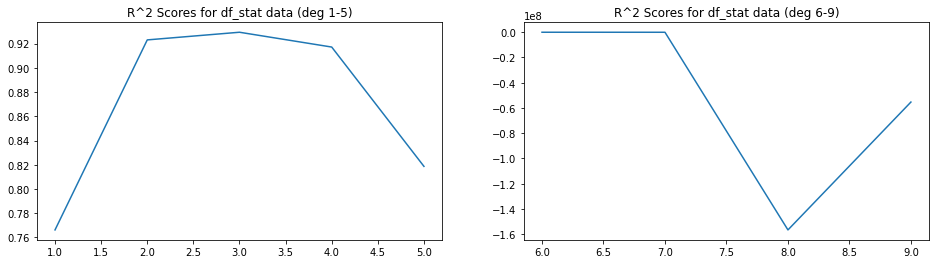

In [50]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
sns.lineplot(x=list(range(1,6)), y=scores_stat[:5])
plt.title('R^2 Scores for df_stat data (deg 1-5)')

plt.subplot(1,2,2)
sns.lineplot(x=list(range(6,10)), y=scores_stat[5:])
plt.title('R^2 Scores for df_stat data (deg 6-9)')

plt.show()

In [51]:
# df_full
scores_full = []
for degree in range(1,10):
    poly = PolynomialFeatures(degree)
    X_full_train_poly = poly.fit_transform(X_full_train_scaled)
    X_full_test_poly = poly.transform(X_full_test_scaled)
    
    lr = LinearRegression().fit(X_full_train_poly, y_full_train)
    scores_full.append(r2_score(y_full_test, lr.predict(X_full_test_poly)))

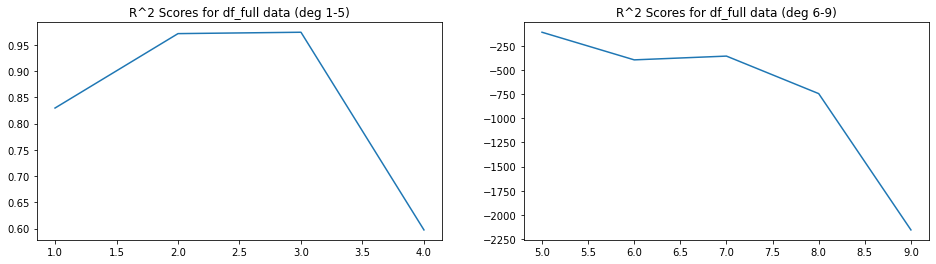

In [52]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
sns.lineplot(x=list(range(1,5)), y=scores_full[:4])
plt.title('R^2 Scores for df_full data (deg 1-5)')

plt.subplot(1,2,2)
sns.lineplot(x=list(range(5,10)), y=scores_full[4:])
plt.title('R^2 Scores for df_full data (deg 6-9)')

plt.show()

**BEST HYPER-PARAMTER(S)**: Polynomial Degree = 3

In [53]:
def get_best_params(df, model, params, is_poly=False):
    best_params = []
    
    kfold = KFold(n_splits=5, shuffle=True, random_state=SEED)
    
    X = df.drop('Market Value', axis=1)
    y = df['Market Value']
    for train_idx, test_idx in kfold.split(X):
        
        X_train = X.iloc[train_idx]
        X_test = X.iloc[test_idx]
        
        y_train = y.iloc[train_idx]
        y_test = y.iloc[test_idx]
        
        scaler = MinMaxScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        gs = GridSearchCV(model, param_grid=params, cv=5, scoring='r2')
        gs.fit(X_train_scaled, y_train)
        best_params.append(gs.best_params_)
        
    return best_params

In [54]:
get_best_params(df_stat, dt, params={'min_samples_split': range(2, 10), 'criterion': ['r2', 'mse', 'mae']})

[{'criterion': 'mse', 'min_samples_split': 9},
 {'criterion': 'mae', 'min_samples_split': 7},
 {'criterion': 'mae', 'min_samples_split': 5},
 {'criterion': 'mae', 'min_samples_split': 5},
 {'criterion': 'mae', 'min_samples_split': 9}]

In [55]:
get_best_params(df_full, dt, params={'min_samples_split': range(2, 10), 'criterion': ['r2', 'mse', 'mae']})

[{'criterion': 'mae', 'min_samples_split': 5},
 {'criterion': 'mse', 'min_samples_split': 9},
 {'criterion': 'mse', 'min_samples_split': 6},
 {'criterion': 'mae', 'min_samples_split': 8},
 {'criterion': 'mae', 'min_samples_split': 7}]

**BEST HYPER-PARAMTER(S)**: `criterion` = mae, `min_samples_split` = 7

In [56]:
get_best_params(df_stat, knn, params={'n_neighbors': list(range(1,21))})

[{'n_neighbors': 8},
 {'n_neighbors': 7},
 {'n_neighbors': 8},
 {'n_neighbors': 7},
 {'n_neighbors': 6}]

In [57]:
get_best_params(df_full, knn, params={'n_neighbors': list(range(1,21))})

[{'n_neighbors': 5},
 {'n_neighbors': 6},
 {'n_neighbors': 6},
 {'n_neighbors': 8},
 {'n_neighbors': 6}]

**BEST HYPER-PARAMTER(S)**: `n_neighbors` = 6

In [58]:
get_best_params(df_stat, rf, params={'n_estimators': list(range(5, 20, 5)), 'max_depth': [4, 6, 8], 'criterion':['r2', 'mse', 'mae']})

[{'criterion': 'mae', 'max_depth': 8, 'n_estimators': 15},
 {'criterion': 'mse', 'max_depth': 8, 'n_estimators': 15},
 {'criterion': 'mse', 'max_depth': 8, 'n_estimators': 10},
 {'criterion': 'mse', 'max_depth': 8, 'n_estimators': 15},
 {'criterion': 'mse', 'max_depth': 8, 'n_estimators': 5}]

In [59]:
get_best_params(df_full, rf, params={'n_estimators': list(range(5, 20, 5)), 'max_depth': [4, 6, 8], 'criterion':['r2', 'mse', 'mae']})

[{'criterion': 'mae', 'max_depth': 8, 'n_estimators': 15},
 {'criterion': 'mse', 'max_depth': 8, 'n_estimators': 15},
 {'criterion': 'mse', 'max_depth': 8, 'n_estimators': 10},
 {'criterion': 'mse', 'max_depth': 8, 'n_estimators': 15},
 {'criterion': 'mse', 'max_depth': 8, 'n_estimators': 5}]

**BEST HYPER-PARAMTER(S)**: `criterion` = mse, `max_depth` = 8, `n_estimators` = 15

### Final Model Evaluation

In [60]:
nb = GaussianNB()
pr = LinearRegression()
dt = DecisionTreeRegressor(criterion='mae', min_samples_split=7, random_state=SEED)
rf = RandomForestRegressor(criterion = 'mse', max_depth = 8, n_estimators = 15, random_state=SEED)
knn = KNeighborsRegressor(n_neighbors=6)

updated_model_dict = {'DummyRegressor':dummy,
                      'NaiveBayes': nb,
                      'PolynomialRegression': pr,
                      'DecisionTree': dt,
                      'RandomForest': rf,
                      'KNN': knn}

#### Evaluating on df_stat

In [61]:
for name, model in updated_model_dict.items():
    if name.startswith('Poly'):
        eval_tuple = evaluate_model(df_stat, (name, model), 'r2', poly_deg=3)
    else:
        eval_tuple = evaluate_model(df_stat, (name, model), 'r2')
        
    print(f'{name:25} Mean R2: {eval_tuple[0]},   STD: {eval_tuple[1]}')

DummyRegressor            Mean R2: -0.0,   STD: 0.0
NaiveBayes                Mean R2: 0.457,   STD: 0.076
PolynomialRegression      Mean R2: 0.817,   STD: 0.027
DecisionTree              Mean R2: 0.844,   STD: 0.026
RandomForest              Mean R2: 0.917,   STD: 0.025
KNN                       Mean R2: 0.779,   STD: 0.027


In [62]:
for name, model in updated_model_dict.items():
    if name.startswith('Poly'):
        eval_tuple = evaluate_model(df_stat, (name, model), 'rmse', poly_deg=3)
    else:
        eval_tuple = evaluate_model(df_stat, (name, model), 'rmse')
        
    print(f'{name:25} Mean RMSE: {eval_tuple[0]},   STD: {eval_tuple[1]}')

DummyRegressor            Mean RMSE: 18207190.152,   STD: 1236168.269
NaiveBayes                Mean RMSE: 13351085.783,   STD: 868956.543
PolynomialRegression      Mean RMSE: 7741599.158,   STD: 506841.129
DecisionTree              Mean RMSE: 7179426.079,   STD: 873139.182
RandomForest              Mean RMSE: 5235527.316,   STD: 1098967.549
KNN                       Mean RMSE: 8574314.425,   STD: 1033394.889


In [63]:
for name, model in updated_model_dict.items():
    if name.startswith('Poly'):
        eval_tuple = evaluate_model(df_stat, (name, model), 'mae', poly_deg=3)
    else:
        eval_tuple = evaluate_model(df_stat, (name, model), 'mae')
        
    print(f'{name:25} Mean MAE: {eval_tuple[0]},   STD: {eval_tuple[1]}')

DummyRegressor            Mean MAE: 11411453.811,   STD: 482498.539
NaiveBayes                Mean MAE: 7461524.901,   STD: 615183.371
PolynomialRegression      Mean MAE: 4944883.634,   STD: 139701.007
DecisionTree              Mean MAE: 2756386.414,   STD: 162955.902
RandomForest              Mean MAE: 2052633.321,   STD: 197428.037
KNN                       Mean MAE: 4022419.016,   STD: 196409.718


#### Evaluating on df_full

In [64]:
for name, model in updated_model_dict.items():
    if name.startswith('Poly'):
        eval_tuple = evaluate_model(df_full, (name, model), 'r2', poly_deg=3)
    else:
        eval_tuple = evaluate_model(df_full, (name, model), 'r2')
        
    print(f'{name:25} Mean R2: {eval_tuple[0]},   STD: {eval_tuple[1]}')

DummyRegressor            Mean R2: -0.0,   STD: 0.0
NaiveBayes                Mean R2: 0.527,   STD: 0.089
PolynomialRegression      Mean R2: 0.957,   STD: 0.01
DecisionTree              Mean R2: 0.916,   STD: 0.016
RandomForest              Mean R2: 0.942,   STD: 0.027
KNN                       Mean R2: 0.776,   STD: 0.023


In [65]:
for name, model in updated_model_dict.items():
    if name.startswith('Poly'):
        eval_tuple = evaluate_model(df_full, (name, model), 'rmse', poly_deg=3)
    else:
        eval_tuple = evaluate_model(df_full, (name, model), 'rmse')
        
    print(f'{name:25} Mean RMSE: {eval_tuple[0]},   STD: {eval_tuple[1]}')

DummyRegressor            Mean RMSE: 18207190.152,   STD: 1236168.269
NaiveBayes                Mean RMSE: 12425794.42,   STD: 1207226.186
PolynomialRegression      Mean RMSE: 3752405.533,   STD: 423138.456
DecisionTree              Mean RMSE: 5283267.022,   STD: 824396.619
RandomForest              Mean RMSE: 4316806.086,   STD: 1346253.746
KNN                       Mean RMSE: 8621742.897,   STD: 964872.533


In [66]:
for name, model in updated_model_dict.items():
    if name.startswith('Poly'):
        eval_tuple = evaluate_model(df_full, (name, model), 'mae', poly_deg=3)
    else:
        eval_tuple = evaluate_model(df_full, (name, model), 'mae')
        
    print(f'{name:25} Mean MAE: {eval_tuple[0]},   STD: {eval_tuple[1]}')

DummyRegressor            Mean MAE: 11411453.811,   STD: 482498.539
NaiveBayes                Mean MAE: 7657330.254,   STD: 568828.367
PolynomialRegression      Mean MAE: 2332422.456,   STD: 46184.688
DecisionTree              Mean MAE: 1729830.805,   STD: 84507.329
RandomForest              Mean MAE: 1339820.248,   STD: 168666.022
KNN                       Mean MAE: 4074139.263,   STD: 168605.889


**Observation**: Polynomial Regression (PR) and Random Forest (RF) were the two best performing metrics. While PR edged out in ${R^2}$ and RMSE, RF had better MAE. PR, however, took longer to build and execute - although this maybe down to the fact that the polynomial feature creation was also included in the model evaluation function.

In [67]:
pr = LinearRegression()
dt = DecisionTreeRegressor(criterion='mae', min_samples_split=7, random_state=SEED)
rf = RandomForestRegressor(criterion = 'mse', max_depth = 8, n_estimators = 15, random_state=SEED)

final_model_dict = {'PolynomialRegression': pr,
                    'DecisionTree': dt,
                    'RandomForest': rf}

### Tradeoff Analysis

#### Bias vs Variance

In [68]:
def calc_tradeoff(df, model, is_poly=False):
#     bias_list = []
#     variance_list = []
    
    X = df.drop('Market Value', axis=1).values
    y = df['Market Value'].values
    
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    if is_poly:
        poly = PolynomialFeatures(3)
        X_train_poly = poly.fit_transform(X_train_scaled)
        X_test_poly = poly.transform(X_test_scaled)
        mse, bias, var = bias_variance_decomp(model, X_train_poly, y_train, X_test_poly, y_test,
                                              loss='mse', random_seed=SEED)

    else:
        mse, bias, var = bias_variance_decomp(model, X_train_scaled, y_train, X_test_scaled, y_test,
                                              loss='mse', random_seed=SEED)

#     bias_list.append(bias/mse)
#     variance_list.append(var/mse)
#         if metric=='r2':
#             scores.append(r2_score(y_test, y_pred))
#         elif metric=='rmse':
#             scores.append(mean_squared_error(y_test, y_pred, squared=False))
#         elif metric=='mae':
#             scores.append(mean_absolute_error(y_test, y_pred))
    
#     mean_bias = round(np.mean(bias_list), 3)
#     mean_variance = round(np.std(variance_list), 3)
    mean_bias = round(bias/mse)
    mean_variance = round(var/mse)
#     rmse_mean = np.format_float_scientific(np.mean(rmse_scores), precision = 2, exp_digits=1)
#     mae_mean = np.format_float_scientific(np.mean(mae_scores), precision = 2, exp_digits=1)
    
    return (mean_bias, mean_variance)

In [69]:
bias_pct_list = []
var_pct_list = []

# PR
poly = PolynomialFeatures(3)
X_train_poly = poly.fit_transform(X_full_train_scaled)
X_test_poly = poly.transform(X_full_test_scaled)

mse, bias, var = bias_variance_decomp(updated_model_dict['DecisionTree'], X_full_train_scaled, y_full_train.values,
                                      X_full_test_scaled, y_full_test.values,
                                      loss='mse', random_seed=SEED)

bias_pct_list.append(bias/mse)
var_pct_list.append(var/mse)

# DT
mse, bias, var = bias_variance_decomp(updated_model_dict['DecisionTree'], X_full_train_scaled, y_full_train.values,
                                      X_full_test_scaled, y_full_test.values,
                                      loss='mse', random_seed=SEED)

bias_pct_list.append(bias/mse)
var_pct_list.append(var/mse)

# RF
mse, bias, var = bias_variance_decomp(updated_model_dict['RandomForest'], X_full_train_scaled, y_full_train.values,
                                      X_full_test_scaled, y_full_test.values,
                                      loss='mse', random_seed=SEED)

bias_pct_list.append(bias/mse)
var_pct_list.append(var/mse)

In [70]:
print(bias_pct_list)
print(var_pct_list)

[0.24170583321803665, 0.24170583321803665, 0.6432355455648452]
[0.7582941667819633, 0.7582941667819633, 0.356764454435155]


In [71]:
bias_var_df = pd.DataFrame(index=['Polynomial Regression', 'Decision Tree','Random Forest'],
                          data={'Bias %':bias_pct_list, 'Variance %':var_pct_list})

bias_var_df['Bias %'] = bias_var_df['Bias %']* 100
bias_var_df['Variance %'] = bias_var_df['Variance %']* 100

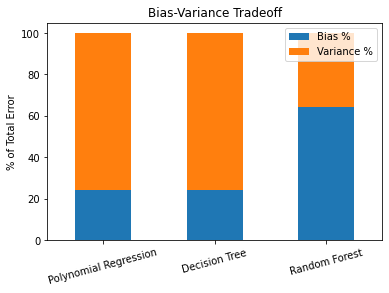

In [110]:
bias_var_df.plot(kind='bar', stacked=True)
plt.xticks(rotation=15)
plt.ylabel('% of Total Error')
plt.title('Bias-Variance Tradeoff')
plt.show()

### Sensitivity Analysis

For this section we will look at the effect of tweaking one **key** hyperparameter for each of our 3 best performing models. The parameters we will tune are:

1. Polynomial Regression - Polynomial Degree
2. Decision Tree - `min_sample_split`
2. Random Forest - `n_estimators`

In [82]:
# deg = list(range(2,5))

# kfold = KFold(n_splits=5, shuffle=True, random_state=SEED)

# X = df_full.drop('Market Value', axis=1)
# y = df_full['Market Value']

# model = final_model_dict['PolynomialRegression']

# for i in deg:
#     deg_r2_score = []
#     for train_idx, test_idx in kfold.split(X):

#         X_train = X.iloc[train_idx]
#         X_test = X.iloc[test_idx]

#         y_train = y.iloc[train_idx]
#         y_test = y.iloc[test_idx]

#         scaler = MinMaxScaler()
#         X_train_scaled = scaler.fit_transform(X_train)
#         X_test_scaled = scaler.transform(X_test)

#         poly = PolynomialFeatures(i)
#         X_train_poly = poly.fit_transform(X_train_scaled)
#         X_test_poly = poly.transform(X_test_scaled)

#         model.fit(X_train_poly, y_train)
#         y_pred = model.predict(X_test_poly)
#         deg_r2_score.append(r2_score(y_test, y_pred))

KeyboardInterrupt: 

In [73]:
min_samples = range(2, 10)

kfold = KFold(n_splits=5, shuffle=True, random_state=SEED)

X = df_full.drop('Market Value', axis=1)
y = df_full['Market Value']

dt_r2_scores = []
for i in min_samples:
    model = DecisionTreeRegressor(min_samples_split=i)
    min_samp_r2_score = []
    for train_idx, test_idx in kfold.split(X):

        X_train = X.iloc[train_idx]
        X_test = X.iloc[test_idx]

        y_train = y.iloc[train_idx]
        y_test = y.iloc[test_idx]

        scaler = MinMaxScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        min_samp_r2_score.append(r2_score(y_test, y_pred))

    dt_r2_scores.append(np.mean(min_samp_r2_score))

In [74]:
dt_r2_scores

[0.8765003316608351,
 0.8681749325733226,
 0.8402717551138071,
 0.8744938412672738,
 0.8856228588826838,
 0.8784197037724695,
 0.878224305987402,
 0.8871133856824291]

Text(0, 0.5, 'Mean R2 Score')

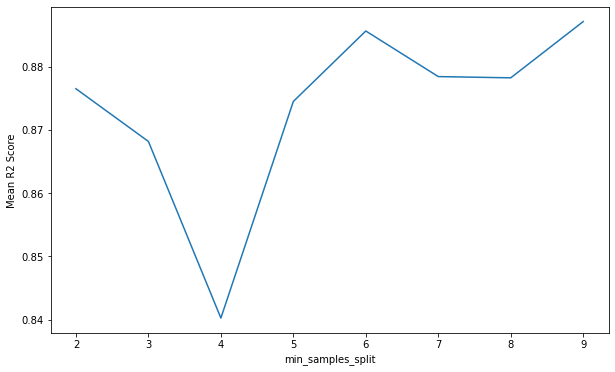

In [80]:
plt.figure(figsize=(10,6))
sns.lineplot(x=list(range(2, 10)), y=dt_r2_scores)
plt.xlabel('min_samples_split')
plt.ylabel('Mean R2 Score')

In [76]:
n_estims = range(1, 21, 5)

kfold = KFold(n_splits=5, shuffle=True, random_state=SEED)

X = df_full.drop('Market Value', axis=1)
y = df_full['Market Value']

rf_r2_scores = []
for i in n_estims:
    model = RandomForestRegressor(n_estimators=i)
    n_estim_r2_score = []
    for train_idx, test_idx in kfold.split(X):

        X_train = X.iloc[train_idx]
        X_test = X.iloc[test_idx]

        y_train = y.iloc[train_idx]
        y_test = y.iloc[test_idx]

        scaler = MinMaxScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        n_estim_r2_score.append(r2_score(y_test, y_pred))

    rf_r2_scores.append(np.mean(n_estim_r2_score))

Text(0, 0.5, 'Mean R2 Score')

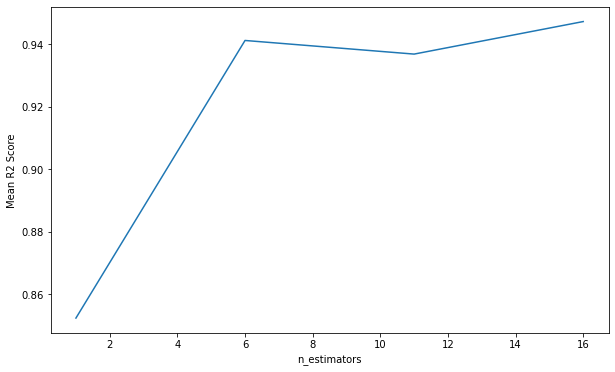

In [81]:
plt.figure(figsize=(10,6))
sns.lineplot(x=list(range(1, 21, 5)), y=rf_r2_scores)
plt.xlabel('n_estimators')
plt.ylabel('Mean R2 Score')

### Feature Importance

In [ ]:
n_estims = range(1, 21, 5)

kfold = KFold(n_splits=5, shuffle=True, random_state=SEED)

X = df_full.drop('Market Value', axis=1)
y = df_full['Market Value']

rf_r2_scores = []
for i in n_estims:
    model = RandomForestRegressor(n_estimators=i)
    n_estim_r2_score = []
    for train_idx, test_idx in kfold.split(X):

        X_train = X.iloc[train_idx]
        X_test = X.iloc[test_idx]

        y_train = y.iloc[train_idx]
        y_test = y.iloc[test_idx]

        scaler = MinMaxScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        n_estim_r2_score.append(r2_score(y_test, y_pred))

    rf_r2_scores.append(np.mean(n_estim_r2_score))

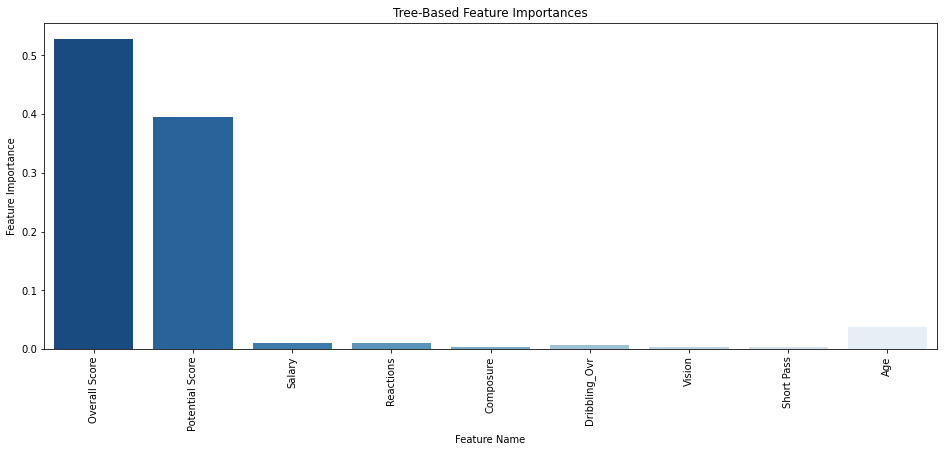

In [85]:
plt.figure(figsize=(16,6))
plt.xticks(rotation=90)
rf_feat = final_model_dict['RandomForest'].fit(X_full_train_scaled, y_full_train)
sns.barplot(y=rf_feat.feature_importances_, x=X_full_train.columns, palette='Blues_r')
plt.title('Tree-Based Feature Importances')
plt.xlabel('Feature Name')
plt.ylabel('Feature Importance')
plt.show()

### Failure Analysis

In [86]:
rf_final = final_model_dict['RandomForest'].fit(X_full_train_scaled, y_full_train)
y_full_pred = rf_final.predict(X_full_test_scaled)

In [87]:
comp_df = pd.DataFrame({'True Value': y_full_test, 'Predicted Value': y_full_pred})
comp_df.head()

,True Value,Predicted Value
913,18000000.0,1.750085e+07
2307,4100000.0,3.952055e+06
2558,6500000.0,6.958323e+06
1119,18500000.0,1.869492e+07
2900,1900000.0,2.343969e+06


In [94]:
comp_df['Difference'] = abs(comp_df['True Value'] - comp_df['Predicted Value'])

In [99]:
comp_df.sort_values(by=['Difference'], inplace=True, ascending=False)

In [104]:
comp_df.merge(df['Player'],left_index=True, right_index=True).head()

,True Value,Predicted Value,Difference,Player
15,101000000.0,1.264467e+08,2.544667e+07,Thibaut Courtois
22,53000000.0,7.686000e+07,2.386000e+07,Luis Suárez
27,111000000.0,8.922367e+07,2.177633e+07,Raheem Sterling
4,148000000.0,1.272000e+08,2.080000e+07,Kevin De Bruyne
9,96500000.0,1.152341e+08,1.873410e+07,Alisson


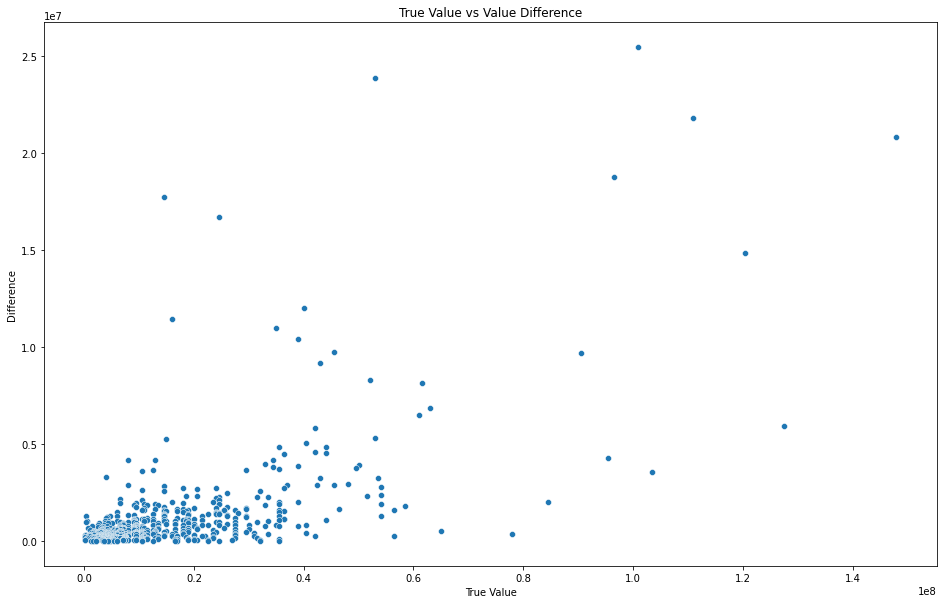

In [107]:
plt.figure(figsize=(16,10))
sns.scatterplot('True Value', 'Difference', data=comp_df)
plt.title('True Value vs Value Difference')
plt.show()